In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f, te, l
from sklearn.metrics import mean_squared_error
import math

In [16]:
BASEPATH = 'C:/Users/Surya/SuryaMain/PythonProjects/Chinook-Growth-Project'
#BASEPATH = '/Users/johnbuckner/github/Chinook-Growth-Project'
SIMULATION_BASEPATH = os.path.join(BASEPATH, "simulate_nonlinear_data")
datasets = sorted([name for name in os.listdir(SIMULATION_BASEPATH) if name[0:4] == 'data'])

In [13]:
def get_data(fname):
    path = os.path.join(SIMULATION_BASEPATH, fname)
    if os.path.exists(path):
        X = pd.read_csv(os.path.join(path, 'X.csv'))
        X.drop(X.columns[0], axis=1, inplace=True)
        y = pd.read_csv(os.path.join(path, 'y.csv'))
        y.drop(y.columns[0], axis=1, inplace=True)
        return [X, y]
    else: 
        print("Dataset does not exist")
        return [0,0]     

class SimGAM(LinearGAM):
    def __init__(self, X, y, **kwargs):
        super().__init__(**kwargs)
        self.X = X
        self.y = y
        self.trained = False
        
    def get_X(self):
        return self.X
    
    def get_Y(self):
        return self.y
    
    @staticmethod 
    def fill_vals(num_vars, var_idx):
        sample = np.zeros(shape=(100, num_vars))
        rand_vals = sorted(np.random.normal(0,1,100))
        for row_idx, row in enumerate(sample):
            row[var_idx] = rand_vals[row_idx]
        return sample    

    def fit_gam(self):
        lams = np.logspace(-5,5,20)*self.X.shape[1]
        super().fit(self.X, self.y)
        super().gridsearch(self.X, self.y, lam=lams)
        self.trained = True
        
    def partial_dependences(self):
        if self.trained == True:
            pds = {}
            num_vars = self.X.shape[1]
            for var in range(num_vars):  # Number of variables
                sample = SimGAM.fill_vals(num_vars, var)
                pdep = super().partial_dependence(term=var, X=sample)
                pds[f'var{var}'] = pdep
            return pds
        else: return None
    
    def calc_aic(self):
        if self.trained == True:
            num_params = len(super().coef_) + 1
            aic = -2*super().loglikelihood(self.X,self.y) + 2*num_params
            return aic
        else: return None

# Variable importance list creator function 
def vi_list(ds):
    datset  = get_data(ds)
    X = datset[0]
    y = datset[1]
    gam = SimGAM(X, y, n_splines=15)
    gam.fit_gam()
    pdeps = gam.partial_dependences()
    pd_variances = np.array([np.var(pdeps[f'var{i}']) for i in range(0, gam.get_X().shape[1])]) 
    return pd_variances

In [ ]:
# Compute variable importance differences
similarity_vals = {
    0.25:[],
    0.50:[],
    0.75:[]
}
for i, ds in enumerate(datasets[0:30]):
    vis_gam = vi_list(ds)
    total_effect = float(pd.read_csv(os.path.join(SIMULATION_BASEPATH, ds, 'hyper_params.csv'))['total_effect'])
    true_imps = np.array(pd.read_csv(os.path.join(SIMULATION_BASEPATH, ds, 'Imp.csv'))['Imp'])
    similarity = np.inner(vis_gam, true_imps) / (np.linalg.norm(vis_gam) * np.linalg.norm(true_imps))
    for key in similarity_vals.keys():
        if total_effect == key:
            similarity_vals[key].append(similarity)

In [53]:
similarity_vals

{0.25: [0.5415341517732767,
  0.3097859536486003,
  0.6924274415665008,
  0.8292823411798926,
  0.7811224133553372,
  0.7601321417403261,
  0.5720897448617679,
  0.48891759577179306,
  0.6516074595316316,
  0.7099106520078056,
  0.3629196807426433],
 0.5: [0.6505524891992887,
  0.5329855450296421,
  0.9202578292919023,
  0.7021332585570689,
  0.6399601453760382,
  0.5829792810911298],
 0.75: [0.9732201617909281,
  0.7133666593347846,
  0.9135022668833382,
  0.7963644101994095,
  0.8589707595337629,
  0.8051022764652755,
  0.69716157420764,
  0.8282252441009536,
  0.7214878715747028,
  0.5548133700501869,
  0.6889208488053932,
  0.6060382081801682,
  0.5240995552857726]}

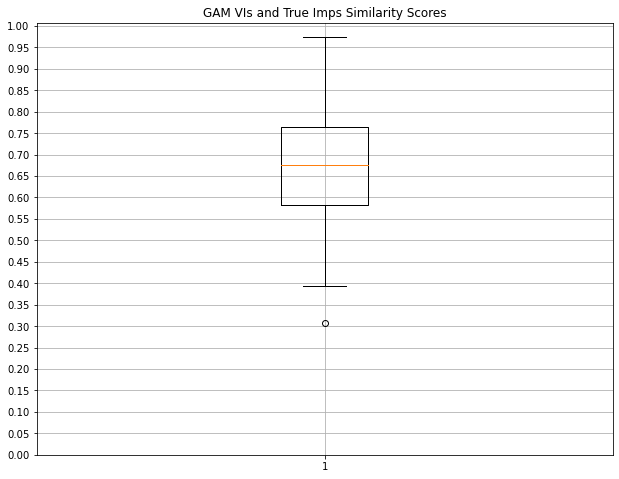

In [48]:
#Boxplot 
fig = plt.figure(figsize=(8,6))

axes = fig.add_axes([0,0,1,1])
axes.boxplot(similarity_vals, showfliers=True)
axes.grid(True)
axes.set_yticks(np.arange(0,1.05,0.05))
axes.set_title('GAM VIs and True Imps Similarity Scores')
plt.show()

In [ ]:
'''   
def pdp(model, nrows, ncols):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    titles = list(map(lambda x:f'V{x}', np.arange(1,len(X.columns)+1)))
    rand_data = []
    for i, ax in enumerate(axs):
        XX = model.model.generate_X_grid(term=i) 
        #sample = np.random.normal(0,1,100)
        ax.plot(XX[:, i], model.model.partial_dependence(term=i, X=XX))
        ax.plot(XX[:, i], model.model.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        ax.set_title(titles[i]);
        ax.grid(True)
        rand_data.append(XX)
    plt.suptitle('Partial Dependence', size=16)
    fig.tight_layout()
    plt.show()
    return rand_data
'''

In [ ]:
def pdp(model, var=0):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    sample = SimGAM.fill_vals(model.get_X().shape[1], var)
    pdep_vals = model.partial_dependences()[f'var{var}']
    ax.plot(sample[:, var], pdep_vals, c='r', ls='--')
    ax.set_title(f'Variable {var+1}: variance = {np.var(pdep_vals)}')
    ax.set_yticks(np.arange(-1,1,0.2))
    ax.grid(True)
    plt.show()

for i in range(10):
    pdp(gam, i)

In [ ]:
'''
def main():
    aic_dict = {}
    for dataset in datasets[0:10]:
        dst = get_data(dataset)
        X = dst[0]
        y = dst[1]
        gam = SimGAM(X,y)
        gam.train_lgam(n_splines=15)
        aic = gam.calc_aic()
        aic_dict[dataset] = aic
    return aic_dict
    
aics = main()
'''